# Pneumonia Classification

## Project Overview

This project documents the process of creating a machine learning model to classify pneumonia.

Pneumonia has a high mortality rate, and rapid, accurate diagnosis is critical for timely treatment. This project aims to create a reliable automated tool to assist medical professionals.


## Content
1. Data Exploration
2. Data Preprocessing
3. Model Training
4. Model Evaluation & Conclusion


**Dataset:** https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images

In [1]:
import kagglehub
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
import shutil

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime

# CNN model imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy

# Transfer learning imports
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.models import load_model

In [2]:
download_path = kagglehub.dataset_download("pcbreviglieri/pneumonia-xray-images")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'pneumonia-xray-images' dataset.
Path to dataset files: /kaggle/input/pneumonia-xray-images


In [4]:
seed_value = 24
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

destination = "/content/pneumonia-xray-images"

shutil.copytree(download_path, destination)

train_dir = f"{destination}/train"
valid_dir = f"{destination}/val"
test_dir = f"{destination}/test"


In [5]:
os.rename(f"{train_dir}/opacity", f"{train_dir}/pneumonia")
os.rename(f"{valid_dir}/opacity", f"{valid_dir}/pneumonia")
os.rename(f"{test_dir}/opacity", f"{test_dir}/pneumonia")

In [6]:
def show_sample_images(data_dir, num_samples=5):
    classes = sorted(os.listdir(data_dir))
    plt.figure(figsize=(15, 7))

    for i, cls in enumerate(classes):
        class_path = os.path.join(data_dir, cls)
        random_images = random.sample(os.listdir(class_path), num_samples)
        for j, img_name in enumerate(random_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Class: {cls}')
            plt.axis('off')
    plt.suptitle('Sample Images from the Training Set', fontsize=16)
    plt.show()


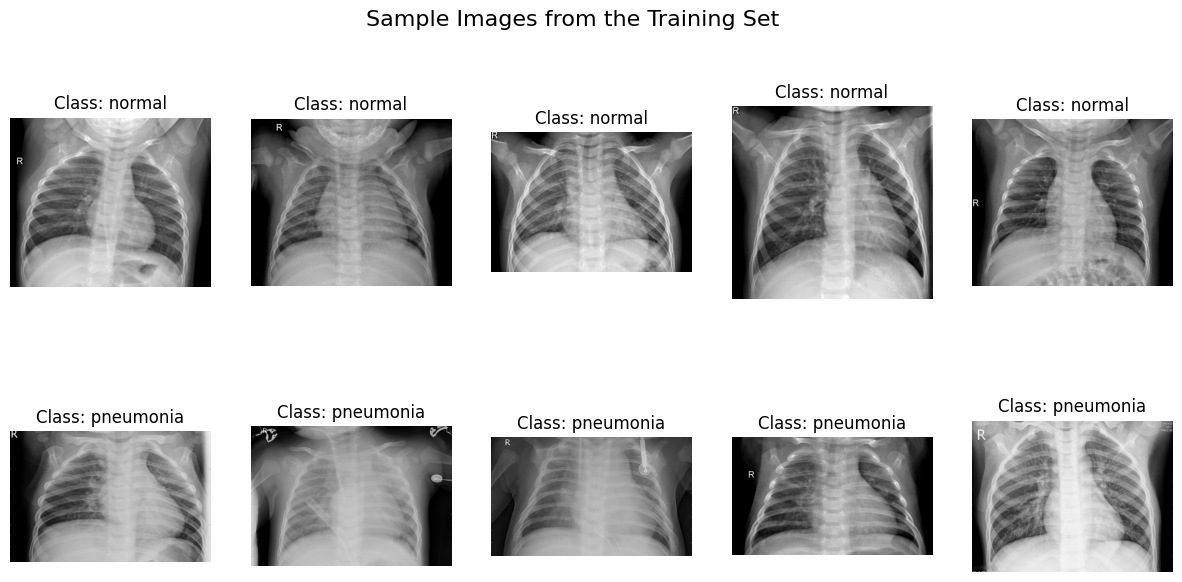

In [7]:
show_sample_images(train_dir)

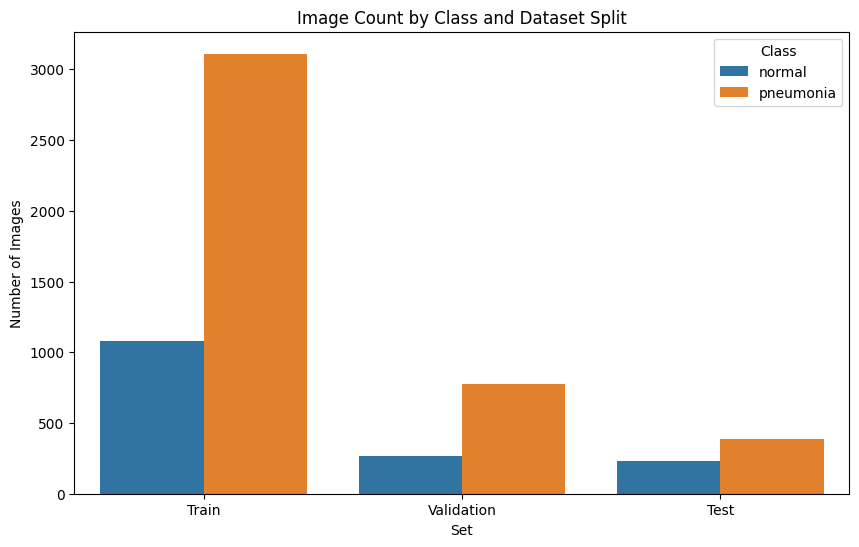

In [8]:
def plot_data_distribution(data_dirs, set_names):
    class_counts = {}
    classes = sorted(os.listdir(data_dirs[0]))

    for i, data_dir in enumerate(data_dirs):
        set_name = set_names[i]
        counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
        class_counts[set_name] = counts

    plot_data = []
    for set_name, counts in class_counts.items():
        for cls, count in counts.items():
            plot_data.append([set_name, cls, count])

    df = pd.DataFrame(plot_data, columns=['Set', 'Class', 'Count'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Set', y='Count', hue='Class', data=df)
    plt.title('Image Count by Class and Dataset Split')
    plt.ylabel('Number of Images')
    plt.show()

plot_data_distribution([train_dir, valid_dir, test_dir], ['Train', 'Validation', 'Test'])

# Data Preprocessing

### Data Augmentation
To prevent overfitting and build a model that is robust to the real world variations in X-ray imaging, the training images were past through a data augmentation pipeline.
* Horizontal Flips: To ensure the model is not biased towards a specific side (left or right lung).
* Rotations (up to 40 degrees): To account for slight variations in patient positioning during the X-ray procedure.
* Zooms and Translations (up to 20%): To handle differences in patient distance from the scanner and centering within the frame.
* Contrast Adjustments (up to 20%): To make the model resilient to variations in X-ray exposure levels.



### Class Imbalance
Initial analysis and training runs revealed a significant class imbalance, with pneumonia cases outnumbering normal cases by nearly 3-to-1. This was addressed by calculating and applying `class_weight` during model training.

### Training and Evaluation
A robust training and evaluation framework was created:
* **Callbacks:** A comprehensive suite of callbacks was used for every training run:
    * `ModelCheckpoint`: To save only the best version of the model based on validation loss.
    * `EarlyStopping`: To prevent wasting time and energy by stopping training when performance plateaus.
    * `ReduceLROnPlateau`: To automatically stabilize training by reducing the learning rate.

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE_LARGE = (224, 224)
IMAGE_SIZE_SMALL = (150, 150)

AUTOTUNE = tf.data.AUTOTUNE

# Loading High-Resolution Data for transfer learning models
train_data_224 = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMAGE_SIZE_LARGE, batch_size=BATCH_SIZE, label_mode="binary"
)
valid_data_224 = tf.keras.utils.image_dataset_from_directory(
    valid_dir, image_size=IMAGE_SIZE_LARGE, batch_size=BATCH_SIZE, label_mode="binary", shuffle=False
)
test_data_224 = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMAGE_SIZE_LARGE, batch_size=BATCH_SIZE, label_mode="binary", shuffle=False
)

# Downscaling to a smaller resolution for CNN models
resizing_layer = tf.keras.layers.Resizing(
    IMAGE_SIZE_SMALL[0], IMAGE_SIZE_SMALL[1]
)

train_data_150 = train_data_224.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE)
valid_data_150 = valid_data_224.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE)
test_data_150 = test_data_224.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=(-40/360, 40/360)),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
])

def configure_dataset(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Applying data augmentation and configuring datasets
train_data_150 = configure_dataset(train_data_150, augment=True)
valid_data_150 = configure_dataset(valid_data_150)
test_data_150 = configure_dataset(test_data_150)

train_data_224 = configure_dataset(train_data_224, augment=True)
valid_data_224 = configure_dataset(valid_data_224)
test_data_224 = configure_dataset(test_data_224)


Found 4192 files belonging to 2 classes.
Found 1040 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [10]:
normal_dir = os.path.join(train_dir, 'normal')
pneumonia_dir = os.path.join(train_dir, 'pneumonia')

num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))
total_samples = num_normal + num_pneumonia

print(f"Found {num_normal} images in normal class.")
print(f"Found {num_pneumonia} images in pneumonia class.")
print(f"Total training samples: {total_samples}")

weight_for_0 = (1 / num_normal) * (total_samples / 2.0)
weight_for_1 = (1 / num_pneumonia) * (total_samples / 2.0)

class_weights_dict = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0 (Normal): {weight_for_0:.2f}")
print(f"Weight for class 1 (Pneumonia): {weight_for_1:.2f}")

Found 1082 images in normal class.
Found 3110 images in pneumonia class.
Total training samples: 4192
Weight for class 0 (Normal): 1.94
Weight for class 1 (Pneumonia): 0.67


## Helper Functions

In [11]:
def create_callbacks(model_name):
    log_dir = f"logs/fit/{model_name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(
            filepath=f'best_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        ),
    ]
    return callbacks

In [12]:
def evaluate_best_model(model_name, test_data):
  model = load_model(f"best_{model_name}.keras")
  test_results = model.evaluate(test_data)
  print("Test Set Evaluation:")
  print(f"Loss: {test_results[0]}")
  print(f"Accuracy: {test_results[1]}")
  print(f"Precision: {test_results[2]}")
  print(f"Recall: {test_results[3]}")
  print(f"F1-Score: {test_results[4]}")

In [13]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(f'Training History for {model_name}', fontsize=16)
    plt.show()

In [14]:
def plot_confusion_matrix(model, test_data, model_name):
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_pred_probs = model.predict(test_data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Normal', 'Pneumonia']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Models

Several model architectures were developed and tested to find the best-performing solution.

1.  **Custom CNN (`model_1`):** A custom CNN using a `Flatten` layer. This served as the first baseline.
2.  **Custom CNN with GAP (`model_2`):** An improved version of the custom model that replaced the `Flatten` layer with `GlobalAveragePooling2D` to reduce parameters and combat overfitting.
3.  **Transfer Learning (`transfer_model_1`):** A `EfficientNetB0` model was used as a feature extractor.
4.  **Fine-Tuned Transfer Learning:** The final step, where the top layers of the `EfficientNetB0` model were unfrozen and trained on the dataset to maximize performance.

In [15]:
model_1 = Sequential([

    Conv2D(64, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),

    Conv2D(128, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),
    Dropout(0.2),

    Conv2D(256, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),
    Dropout(0.3),


    Flatten(),
    Dense(128, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_1.compile(
    optimizer=AdamW(),
    loss=BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)
    ]
)

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_1 = model_1.fit(train_data_150, epochs=25, validation_data=valid_data_150, class_weight=class_weights_dict, callbacks=create_callbacks("model_1"))

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7777 - f1_score: 0.8323 - loss: 0.4886 - precision: 0.9318 - recall: 0.7541
Epoch 1: val_loss improved from inf to 0.83705, saving model to best_model_1.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 90s 436ms/step - accuracy: 0.7779 - f1_score: 0.8325 - loss: 0.4881 - precision: 0.9318 - recall: 0.7545 - val_accuracy: 0.7067 - val_f1_score: 0.8276 - val_loss: 0.8370 - val_precision: 0.7349 - val_recall: 0.9470 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8627 - f1_score: 0.9015 - loss: 0.3063 - precision: 0.9590 - recall: 0.8505
Epoch 2: val_loss did not improve from 0.83705
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.8627 - f1_score: 0.9015 - loss: 0.3062 - precision: 0.9590 - recall: 0.8505 - val_accuracy: 0.7433 - val_f1_score: 0.8527 - val_loss: 2.1431 - val_precision: 0.7433 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 159

In [17]:
evaluate_best_model("model_1", train_data_150)

131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9837 - f1_score: 0.9891 - loss: 0.0527 - precision: 0.9814 - recall: 0.9970
Test Set Evaluation:
Loss: 0.05039789527654648
Accuracy: 0.9852099418640137
Precision: 0.9844246506690979
Recall: 0.9958199262619019
F1-Score: 0.9900894165039062


In [18]:
model_2 = Sequential([
    Conv2D(64, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),

    Conv2D(128, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),
    Dropout(0.2),

    Conv2D(256, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, 3, padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2),
    Dropout(0.3),


    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_2.compile(
    optimizer=AdamW(),
    loss=BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)
    ]
)

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_2 = model_2.fit(train_data_150, epochs=25, validation_data=valid_data_150, class_weight=class_weights_dict, callbacks=create_callbacks("model_2"))

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7821 - f1_score: 0.8398 - loss: 0.4937 - precision: 0.9174 - recall: 0.7745
Epoch 1: val_loss improved from inf to 1.86391, saving model to best_model_2.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.7823 - f1_score: 0.8400 - loss: 0.4932 - precision: 0.9176 - recall: 0.7747 - val_accuracy: 0.7433 - val_f1_score: 0.8527 - val_loss: 1.8639 - val_precision: 0.7433 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8515 - f1_score: 0.8929 - loss: 0.3477 - precision: 0.9558 - recall: 0.8378
Epoch 2: val_loss improved from 1.86391 to 1.84546, saving model to best_model_2.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.8515 - f1_score: 0.8929 - loss: 0.3477 - precision: 0.9558 - recall: 0.8379 - val_accuracy: 0.7433 - val_f1_score: 0.8527 - val_loss: 1.8455 - val_precision: 0.7433 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 

In [20]:
evaluate_best_model("model_2", test_data_150)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7643 - f1_score: 0.5213 - loss: 0.6226 - precision: 0.4506 - recall: 0.6501
Test Set Evaluation:
Loss: 0.3815459609031677
Accuracy: 0.8573718070983887
Precision: 0.8307692408561707
Recall: 0.9692307710647583
F1-Score: 0.89467453956604


In [21]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMAGE_SIZE_LARGE, 3)
)

base_model.trainable = False

transfer_model_1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

transfer_model_1.compile(
    optimizer=AdamW(),
    loss=BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)
    ]
)


transfer_model_1.summary

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<bound method Model.summary of <Sequential name=sequential_3, built=True>>

In [22]:
history_3 = transfer_model_1.fit(train_data_224, epochs=25, validation_data=valid_data_224, class_weight=class_weights_dict, callbacks=create_callbacks("transfer_model_1"))

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.4633 - f1_score: 0.5510 - loss: 0.7139 - precision: 0.7148 - recall: 0.4504
Epoch 1: val_loss improved from inf to 0.70625, saving model to best_transfer_model_1.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 742ms/step - accuracy: 0.4635 - f1_score: 0.5512 - loss: 0.7139 - precision: 0.7149 - recall: 0.4507 - val_accuracy: 0.2567 - val_f1_score: 0.0000e+00 - val_loss: 0.7062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4594 - f1_score: 0.5287 - loss: 0.7122 - precision: 0.7285 - recall: 0.4193
Epoch 2: val_loss improved from 0.70625 to 0.70607, saving model to best_transfer_model_1.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4600 - f1_score: 0.5297 - loss: 0.7121 - precision: 0.7286 - recall: 0.4206 - val_accuracy: 0.2567 - val_f1_score: 0.0000e+00 - val_loss: 0.7061 - val_precision: 0.0000e+00 - val_recall: 0

In [23]:
evaluate_best_model("transfer_model_1", test_data_224)

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.2984 - f1_score: 0.3986 - loss: 0.7005 - precision: 0.2984 - recall: 0.6667
Test Set Evaluation:
Loss: 0.6885076761245728
Accuracy: 0.625
Precision: 0.625
Recall: 1.0
F1-Score: 0.7692307233810425


In [24]:
best_transfer_model = tf.keras.models.load_model('best_transfer_model_1.keras')

best_transfer_model.get_layer('efficientnetb0').trainable = True
for layer in best_transfer_model.get_layer('efficientnetb0').layers[:-20]:
    layer.trainable = False


best_transfer_model.compile(
    optimizer=AdamW(learning_rate=1e-5),
    loss=BinaryCrossentropy(),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', threshold=0.5)
    ]
)

In [25]:
initial_epochs = len(history_3.history['loss'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_4 = best_transfer_model.fit(
    train_data_224,
    epochs=total_epochs,
    initial_epoch=history_3.epoch[-1],
    validation_data=valid_data_224,
    class_weight=class_weights_dict,
    callbacks=create_callbacks("transfer_model_1_finetuned")
)

Epoch 22/32
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4550 - f1_score: 0.5177 - loss: 0.7105 - precision: 0.7382 - recall: 0.4002
Epoch 22: val_loss improved from inf to 0.66264, saving model to best_transfer_model_1_finetuned.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.4557 - f1_score: 0.5187 - loss: 0.7104 - precision: 0.7384 - recall: 0.4015 - val_accuracy: 0.7433 - val_f1_score: 0.8527 - val_loss: 0.6626 - val_precision: 0.7433 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 23/32
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4814 - f1_score: 0.5754 - loss: 0.7066 - precision: 0.7238 - recall: 0.4786
Epoch 23: val_loss did not improve from 0.66264
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4816 - f1_score: 0.5757 - loss: 0.7066 - precision: 0.7239 - recall: 0.4790 - val_accuracy: 0.7433 - val_f1_score: 0.8527 - val_loss: 0.6783 - val_precision: 0.7433 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 24/32
131/131

In [26]:
evaluate_best_model("transfer_model_1_finetuned", test_data_224)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - accuracy: 0.2984 - f1_score: 0.3986 - loss: 0.7217 - precision: 0.2984 - recall: 0.6667
Test Set Evaluation:
Loss: 0.6784566044807434
Accuracy: 0.625
Precision: 0.625
Recall: 1.0
F1-Score: 0.7692307233810425


## Final Results and Conclusion


### Definitive Model Comparison

| Metric    | Model 1 (Custom CNN w/Flatten) | Model 2 (CNN w/ GAP) | Transfer Learning | Fine-Tuned Transfer |
| :-------- |:------------------------| :------------------- | :---------------- | :-------------------- |
| **Accuracy** | **98.5%**               | 85.7%                | 62.5%             | 62.5%                 |
| **Precision** | **98.4%**               | 83.1%                | 62.5%             | 62.5%                 |
| **Recall** | 99.6%                   | 96.9%                | **100%** | **100%** |
| **F1-Score** | **99.0%**               | 89.5%                | 76.9%             | 76.9%                 |


### Analysis
From the results above, it is clear that **Model 1 (Custom CNN w/Flatten)** is the best performing model. It achieved the highest scores in Accuracy, Precision and F1-Score, while maintaining a high Recall of 99.6%.

In contrast, both transfer learning models (base and fine-tuned) preformed poorly. Looking at the confusion matrices produced by each model (see below for confusion matrices), they show that both models collapsed into a simplistic strategy of always predicting "pneumonia" to achieve a perfect recall score. This resulted in an unacceptably low precision score of 62.5%, making both models unsuitable for any practical use

### Conclusion
Unexpectedly, the most effective solution ended up being **Model 1 (Custom CNN w/Flatten)**. Achieving a 99.0% F1-Score and 99.6% Recall, the model provided the best balance between sensitivity and specificity, making it a highly reliable tool for the classification of pneumonia from chest X-rays.


## Detailed Model Evaluation & Visualizations

The following plots provide a detailed, visual breakdown of each model's training process and final performance on the test set.

--- Results for Model 1: Custom CNN w/ Flatten ---


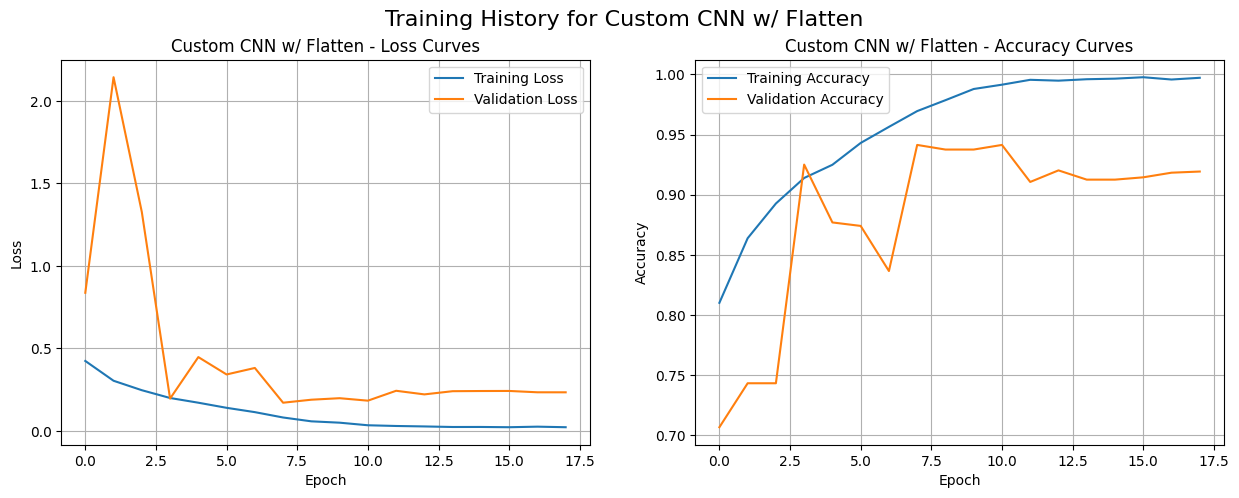

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


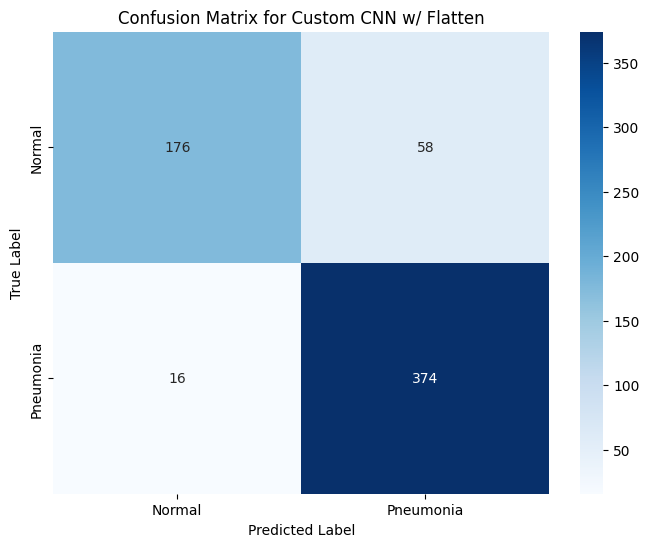

--- Results for Model 2: Custom CNN w/ GAP ---


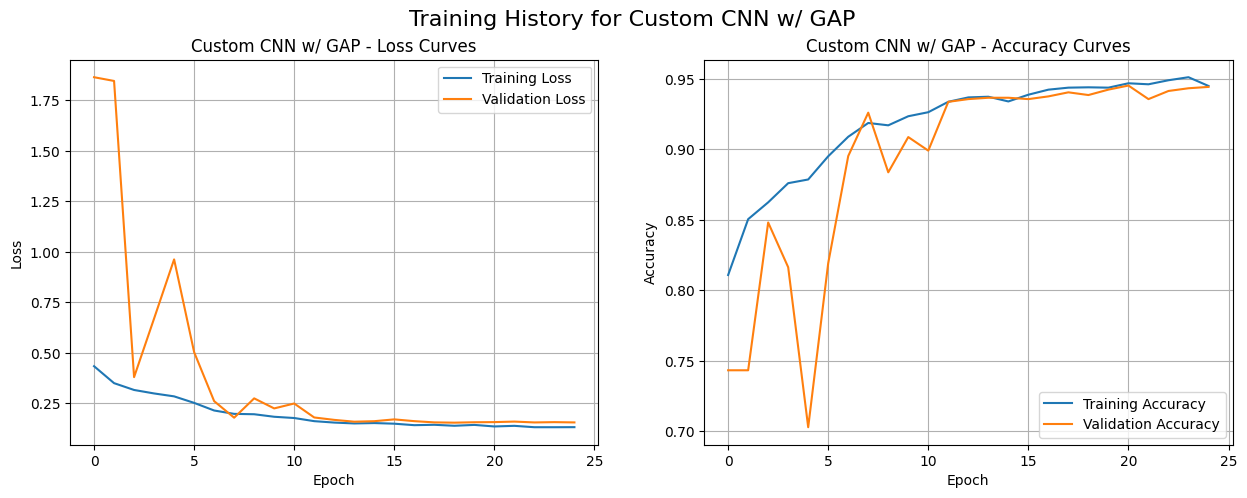

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


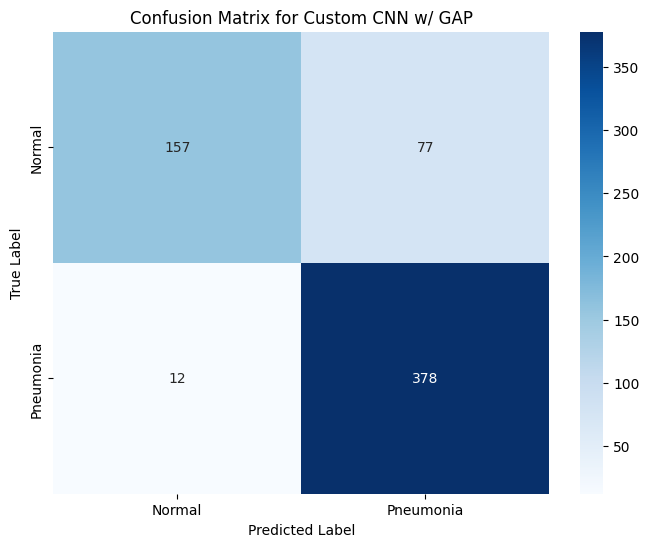

--- Results for Model 3: Transfer Learning Model ---


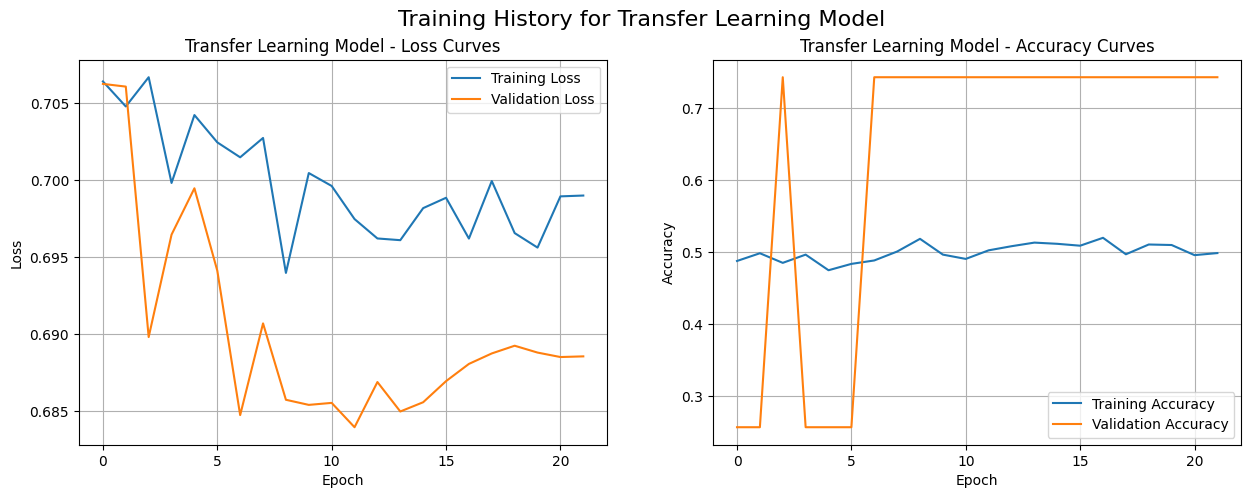

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 386ms/step


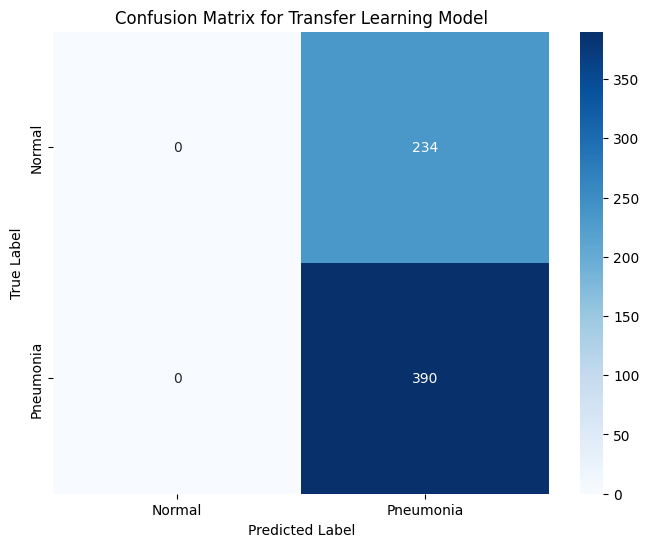

--- Results for Model 4: Finetuned Transfer Learning Model ---


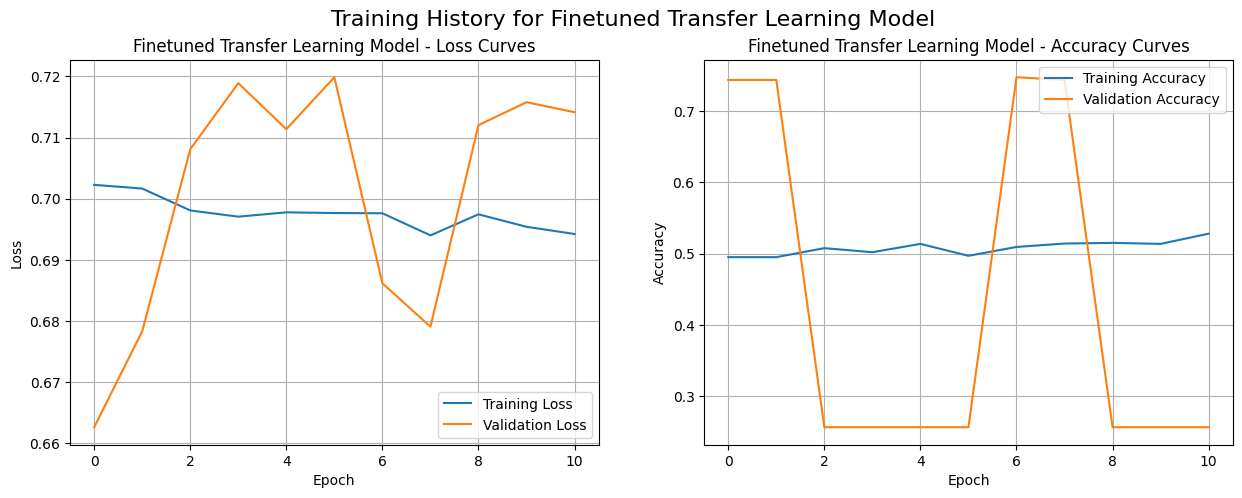

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step


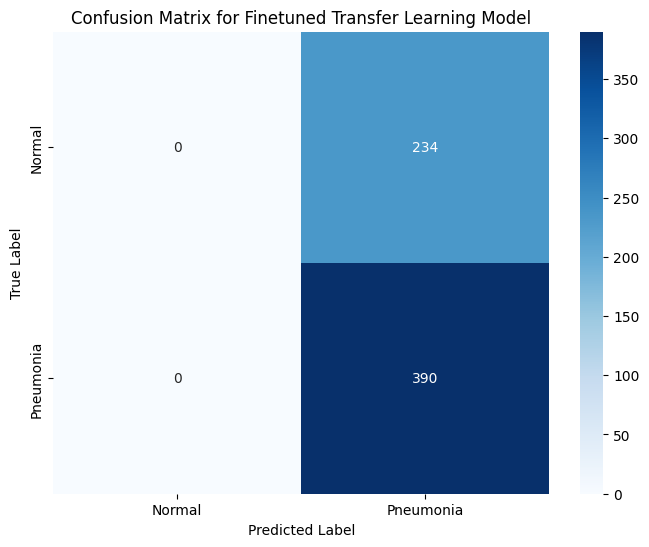

In [29]:
print("--- Results for Model 1: Custom CNN w/ Flatten ---")
plot_history(history_1, "Custom CNN w/ Flatten")

model_1_best = tf.keras.models.load_model('best_model_1.keras')
plot_confusion_matrix(model_1_best, test_data_150, "Custom CNN w/ Flatten")


print("--- Results for Model 2: Custom CNN w/ GAP ---")
plot_history(history_2, "Custom CNN w/ GAP")

model_2_best = tf.keras.models.load_model('best_model_2.keras')
plot_confusion_matrix(model_2_best, test_data_150, "Custom CNN w/ GAP")

print("--- Results for Model 3: Transfer Learning Model ---")
plot_history(history_3, "Transfer Learning Model")

model_3_best = tf.keras.models.load_model('best_transfer_model_1.keras')
plot_confusion_matrix(model_3_best, test_data_224, "Transfer Learning Model")


print("--- Results for Model 4: Finetuned Transfer Learning Model ---")
plot_history(history_4, "Finetuned Transfer Learning Model")

model_4_best = tf.keras.models.load_model('best_transfer_model_1_finetuned.keras')
plot_confusion_matrix(model_4_best, test_data_224, "Finetuned Transfer Learning Model")

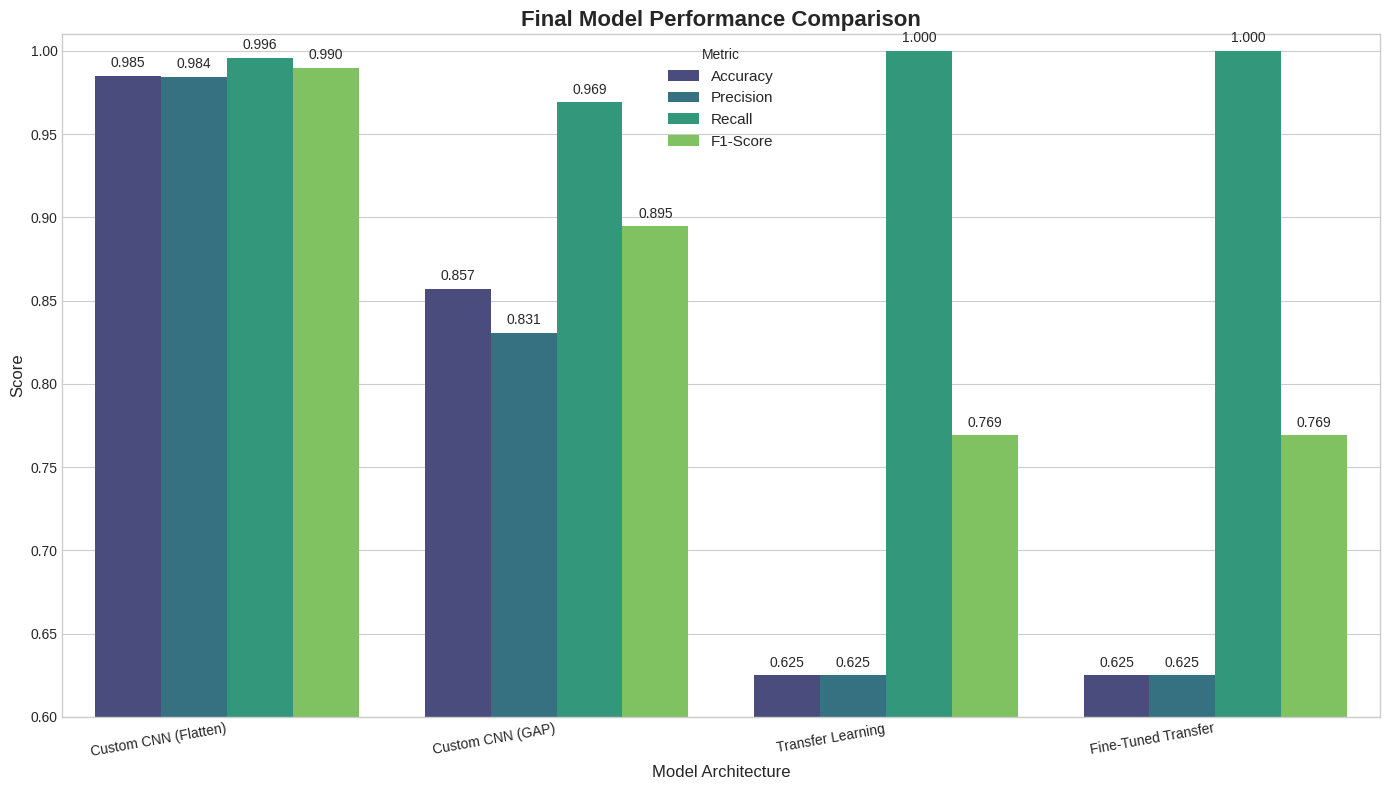

In [30]:
results_data = {
    'Model': [
        'Custom CNN (Flatten)', 'Custom CNN (Flatten)', 'Custom CNN (Flatten)', 'Custom CNN (Flatten)',
        'Custom CNN (GAP)', 'Custom CNN (GAP)', 'Custom CNN (GAP)', 'Custom CNN (GAP)',
        'Transfer Learning', 'Transfer Learning', 'Transfer Learning', 'Transfer Learning',
        'Fine-Tuned Transfer', 'Fine-Tuned Transfer', 'Fine-Tuned Transfer', 'Fine-Tuned Transfer'
    ],
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Accuracy', 'Precision', 'Recall', 'F1-Score'
    ],
    'Score': [
        0.9852, 0.9844, 0.9958, 0.9900,
        0.8573, 0.8307, 0.9692, 0.8946,
        0.6250, 0.6250, 1.0000, 0.7692,
        0.6250, 0.6250, 1.0000, 0.7692
    ]
}

results_df = pd.DataFrame(results_data)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

ax = sns.barplot(x='Model', y='Score', hue='Metric', data=results_df, palette='viridis')

plt.title('Final Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model Architecture', fontsize=12)
plt.xticks(rotation=10, ha='right')
plt.ylim(0.60, 1.01)
plt.legend(title='Metric', fontsize=11)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()
